  Mounting on the drive

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
DATA_DIR = '/content/drive/MyDrive/SML'

Import Library

In [79]:
!pip install tensorflow-addons==0.8.3

In [80]:
%load_ext tensorboard

import datetime

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Import the dataset

In [81]:
train = pd.read_csv(DATA_DIR + "/train.csv")
train["date_time"] = pd.to_datetime(train["date_time"], format = "%Y-%m-%d %H:%M:%S")
test = pd.read_csv(DATA_DIR + "/test.csv")
test["date_time"] = pd.to_datetime(test["date_time"], format = "%Y-%m-%d %H:%M:%S")

In [82]:
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['weekday'] = train['date_time'].dt.dayofweek
train["working_hours"] =  train["hour"].isin(np.arange(8, 21, 1)).astype("int")
train["weekend"] = (train["date_time"].dt.dayofweek >= 5).astype("int")

In [83]:
train = train[['date_time',
                'deg_C',
                'hour',
                'day',
                'weekday',
                'weekend',
                'working_hours',
                'relative_humidity',
                'absolute_humidity',
                'sensor_1',
                'sensor_2',
                'sensor_3',
                'sensor_4',
                'sensor_5',
                'target_carbon_monoxide',
                'target_benzene',
                'target_nitrogen_oxides'
                 ]]

Extrat date and time

In [84]:
test['date_time'] = test['date_time'].astype('datetime64[ns]')
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['weekday'] = test['date_time'].dt.dayofweek
test["working_hours"] =  test["hour"].isin(np.arange(8, 21, 1)).astype("int")
test["weekend"] = (test["date_time"].dt.dayofweek >= 5).astype("int")

In [85]:
test = test[['date_time',
                'deg_C',
                'hour',
                'day',
                'weekday',
                'weekend',
                'working_hours',
                'relative_humidity',
                'absolute_humidity',
                'sensor_1',
                'sensor_2',
                'sensor_3',
                'sensor_4',
                'sensor_5'
                 ]]

Normalization


In [86]:
minmax = MinMaxScaler()
train_df = train.iloc[:,1:-3]
test_df = test.iloc[:,1:]
all_df = pd.concat([train_df,test_df], axis = 0)
all_df = pd.DataFrame(minmax.fit_transform(all_df))
X = all_df.iloc[:len(train),:]
test = all_df.iloc[len(train):,:]
y = train.iloc[:,-3:]
X.shape, test.shape, y.shape

((7111, 13), (2247, 13), (7111, 3))

In [87]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.31106,0.78261,0.30000,0.33333,0.00000,1.00000,0.45299,0.28007,0.52241,0.37587,0.33029,0.51012,0.45231
1,0.31315,0.82609,0.30000,0.33333,0.00000,1.00000,0.44444,0.26428,0.44877,0.27333,0.39299,0.38759,0.33340
2,0.30063,0.86957,0.30000,0.33333,0.00000,1.00000,0.57753,0.27635,0.48474,0.29460,0.33215,0.44457,0.37806
3,0.26722,0.91304,0.30000,0.33333,0.00000,0.00000,0.65324,0.29419,0.47732,0.29429,0.35107,0.42382,0.43960
4,0.28601,0.95652,0.30000,0.33333,0.00000,0.00000,0.61172,0.29522,0.44394,0.25509,0.38563,0.37320,0.38446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106,0.22965,0.86957,1.00000,0.66667,0.00000,1.00000,0.28205,0.09891,0.25899,0.23376,0.24920,0.16131,0.29114
7107,0.22756,0.91304,1.00000,0.66667,0.00000,0.00000,0.29670,0.09378,0.27411,0.22287,0.28403,0.16294,0.28816
7108,0.23800,0.95652,1.00000,0.66667,0.00000,0.00000,0.31380,0.12036,0.28890,0.21121,0.24428,0.15303,0.39578
7109,0.20459,1.00000,1.00000,0.66667,0.00000,0.00000,0.38828,0.10937,0.22650,0.17247,0.26493,0.16466,0.41565


Training and Testing split

In [88]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training and Validation Split

In [89]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [90]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12
5837,0.19833,1.00000,0.23333,0.00000,0.00000,0.00000,0.60317,0.23139,0.16798,0.26053,0.25257,0.26309,0.31505
2573,0.54071,1.00000,0.80000,0.66667,0.00000,0.00000,0.26618,0.36265,0.28822,0.34494,0.23130,0.43616,0.36278
5704,0.50313,0.43478,0.06667,0.33333,0.00000,1.00000,0.46642,0.60514,0.46356,0.46270,0.08645,0.51326,0.50370
3555,0.47808,0.91304,0.13333,0.50000,0.00000,0.00000,0.94994,0.87328,0.21907,0.21121,0.21907,0.42604,0.27991
2329,0.63048,0.82609,0.46667,0.16667,0.00000,1.00000,0.27228,0.50100,0.34046,0.48788,0.14569,0.63487,0.39877
...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.31106,0.17391,0.36667,0.00000,0.00000,0.00000,0.24176,0.14763,0.10579,0.04963,0.71814,0.18457,0.02092
6407,0.36117,0.73913,0.03333,0.50000,0.00000,1.00000,0.72161,0.53071,0.65143,0.57003,0.07205,0.59153,0.66104
5625,0.46973,0.13043,1.00000,1.00000,1.00000,0.00000,0.68498,0.67566,0.24033,0.20582,0.27543,0.34346,0.20490
5759,0.54280,0.73913,0.13333,0.66667,0.00000,1.00000,0.56654,0.64600,0.78760,0.71095,0.01790,0.87174,0.83740


In [91]:
y_carbon = y_train['target_carbon_monoxide']
y_benzene = y_train['target_benzene']
y_nitrogen = y_train['target_nitrogen_oxides']
yval_carbon = y_val['target_carbon_monoxide']
yval_benzene = y_val['target_benzene']
yval_nitrogen = y_val['target_nitrogen_oxides']

y_c = y['target_carbon_monoxide']
y_b = y['target_benzene']
y_n = y['target_nitrogen_oxides']
ytst_carbon = y_test['target_carbon_monoxide']
ytst_benzene = y_test['target_benzene']
ytst_nitrogen = y_test['target_nitrogen_oxides']

In [92]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [93]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()
mse = tf.keras.losses.MeanSquaredError()
mape = tf.keras.losses.MeanAbsolutePercentageError()
mae = tf.keras.losses.MeanAbsoluteError()

callback = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_loss', min_delta=1e-6, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=40, verbose=0,
    mode='auto')

Model for Benzene

In [94]:
#Dependencies
# Neural network
def make_model_benzene():
  model = Sequential()
  model.add(Dense(1024, input_dim=13, kernel_initializer='random_normal',))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(1024))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Dense(128))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.05))

  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='linear'))

  model.summary()

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005),
             loss= msle,
             metrics=['mae', 'mse', 'mape'])
  
  return model

Model for Carbon

In [95]:
def make_model_carbon():
  model = Sequential()
  model.add(Dense(2048, input_dim=13, kernel_initializer='random_normal',))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(1024))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Dense(128))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.05))

  #model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='linear'))

  model.summary()

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005, decay = 5e-4),
             loss= msle,
             metrics=['mae', 'mse', 'mape'])
  
  return model

Model for Ntrogen

In [96]:
def make_model_nitrogen():
  model = Sequential()
  model.add(Dense(2048, input_dim=13, kernel_initializer='random_normal',))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(2048))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(1024))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(1024))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Dense(128))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.05))

  model.add(Dense(32, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='linear'))

  model.summary()

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005),
             loss = msle,
             metrics=['mae', 'mse', 'mape'])
  
  return model

In [97]:
model_benzene = make_model_benzene()
history_benzene = model_benzene.fit(X_train, y_benzene, epochs=400, verbose=True, 
                                    validation_data = (X_val, yval_benzene), batch_size = 2048, callbacks = [plateau, callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              14336     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1024)              0         
                                                        

In [98]:
model_carbon = make_model_carbon()
history_carbon = model_carbon.fit(X_train, y_carbon, epochs=400, verbose=True,
                                  validation_data = (X_val, yval_carbon), batch_size = 1024, callbacks = [plateau,callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 2048)              28672     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 2048)              0         
                                                                 
 batch_normalization_7 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              2098176   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1024)              0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 3s 155ms/step - loss: 0.7387 - mae: 4.0819 - mse: 27.9499 - mape: 388.7813 - val_loss: 2.7533 - val_mae: 17.2913 - val_mse: 415.2786 - val_mape: 1282.9103 - lr: 0.0050
Epoch 2/400
5/5 [==============================] - 0s 41ms/step - loss: 0.2348 - mae: 4.5047 - mse: 57.5835 - mape: 641.3919 - val_loss: 7.0471 - val_mae: 47.3342 - val_mse: 2875.7573 - val_mape: 2982.3228 - lr: 0.0050
Epoch 3/400
5/5 [==============================] - 0s 42ms/step - loss: 0.1538 - mae: 4.0902 - mse: 64.6681 - mape: 646.6419 - val_loss: 6.8216 - val_mae: 39.3767 - val_mse: 1832.9222 - val_mape: 2384.0151 - lr: 0.0050
Epoch 4/400
5/5 [==============================] - 0s 40ms/step - loss: 0.1124 - mae: 3.5305 - mse: 63.4772 - mape: 618.9070 - val_loss: 6.0672 - val_mae: 31.6935 - val_mse: 1110.0220 - val_mape: 2065.4443 - lr: 0.0050
Epoch 5/400
5/5 [==============================] - 0s 45ms/step - loss: 0.0885 - mae: 3.1320 - mse: 62.4037 - mape: 600.0328 - val_loss:

In [99]:
model_nitrogen = make_model_nitrogen()
history_nitrogen = model_nitrogen.fit(X_train, y_nitrogen, epochs=400, verbose=True, 
                                      validation_data = (X_val, yval_nitrogen), batch_size = 4096, callbacks = [callback, plateau])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 2048)              28672     
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 2048)              0         
                                                                 
 batch_normalization_14 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 2048)              4196352   
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 2048)              0         
                                                      

In [100]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()  

Training and validation loss graph

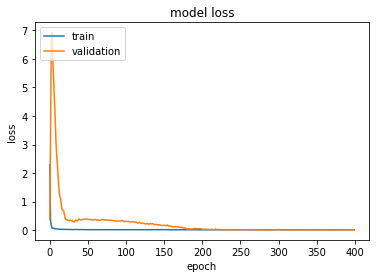

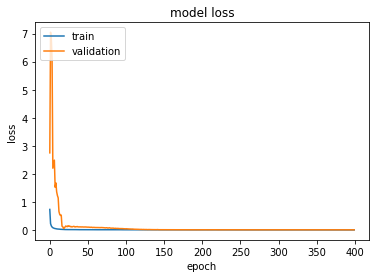

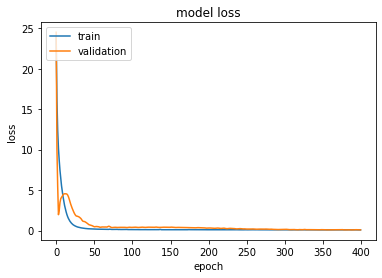

In [101]:
plot_loss(history_benzene)
plot_loss(history_carbon)
plot_loss(history_nitrogen)

Predicting the result

In [102]:
ypred_benzene = model_benzene.predict(X_val)
ypred_carbon = model_carbon.predict(X_val)
ypred_nitrogen = model_nitrogen.predict(X_val)

In [103]:
pred_benzene = list(np.concatenate(ypred_benzene.tolist()).flat)
y_val_benzene = list(yval_benzene)

pred_carbon = list(np.concatenate(ypred_carbon.tolist()).flat)
y_val_carbon = list(yval_carbon)

pred_nitrogen = list(np.concatenate(ypred_nitrogen.tolist()).flat)
y_val_nitrogen = list(yval_nitrogen)


Validation MAPE


In [104]:
mape_b = mape(y_val_benzene, pred_benzene).numpy()
mape_c = mape(y_val_carbon, pred_carbon).numpy()
mape_n = mape(y_val_nitrogen, pred_nitrogen).numpy()
(mape_b+mape_c+mape_n)/3

17.301705678304035

Validation MAE

In [105]:
mae_b = mae(y_val_benzene, pred_benzene).numpy()
mae_c = mae(y_val_carbon, pred_carbon).numpy()
mae_n = mae(y_val_nitrogen, pred_nitrogen).numpy()
(mae_b+mae_c+mae_n)/3

15.559239347775778

Validation RMSLE

In [106]:
rmsleb = np.sqrt(msle(y_val_benzene,pred_benzene))
rmslec = np.sqrt(msle(y_val_carbon, pred_carbon))
rmslen = np.sqrt(msle(y_val_nitrogen, pred_nitrogen)) 
(rmsleb + rmslec + rmslen)/3

0.17110272306081423

Validation RMSE

In [107]:
mse_b = np.sqrt(mse(y_val_benzene, pred_benzene).numpy())
mse_c = np.sqrt(mse(y_val_carbon, pred_carbon).numpy())
mse_n = np.sqrt(mse(y_val_nitrogen, pred_nitrogen).numpy())
(mse_b+mse_c+mse_n)/3

25.541116557214718

Validation $R^2$

In [108]:
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_val_nitrogen, pred_nitrogen)
r2_b = metric.result()
metric.update_state(y_val_nitrogen, pred_nitrogen)
r2_c = metric.result()
metric.update_state(y_val_nitrogen, pred_nitrogen)
r2_n = metric.result()
((r2_b + r2_c + r2_n)/3).numpy()

0.84740734

Training model again on Testing and Valiation data combined

In [109]:
model_benzene = make_model_benzene()
history_benzene = model_benzene.fit(X, y_b, epochs=400, verbose=True, 
                                    validation_data = (X_test, ytst_benzene), batch_size = 2048)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 1024)              14336     
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 1024)              0         
                                                                 
 batch_normalization_23 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_23 (Dropout)        (None, 1024)              0         
                                                                 
 dense_31 (Dense)            (None, 1024)              1049600   
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 1024)              0         
                                                      

Save the model

In [113]:
filename = DATA_DIR + '/Models/Benzene'
model_benzene.save(filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SML/Models/Benzene/assets


Load the model

In [114]:
filename = DATA_DIR + '/Models/Benzene'
model_benzene = tf.keras.models.load_model(filename)
print(model_benzene)

In [115]:
model_carbon = make_model_carbon()
history_carbon = model_carbon.fit(X, y_c, epochs=400, verbose=True,
                                  validation_data = (X_test, ytst_carbon), batch_size = 1024)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 2048)              28672     
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 2048)              0         
                                                                 
 batch_normalization_30 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_30 (Dropout)        (None, 2048)              0         
                                                                 
 dense_40 (Dense)            (None, 1024)              2098176   
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 1024)              0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6/6 [==============================] - 3s 125ms/step - loss: 0.5381 - mae: 2.3475 - mse: 9.3992 - mape: 196.2354 - val_loss: 5.9534 - val_mae: 36.1113 - val_mse: 1693.7583 - val_mape: 1962.3964
Epoch 2/400
6/6 [==============================] - 0s 43ms/step - loss: 0.1370 - mae: 1.2337 - mse: 4.3632 - mape: 137.0938 - val_loss: 6.3655 - val_mae: 40.6342 - val_mse: 2183.0205 - val_mape: 2229.3674
Epoch 3/400
6/6 [==============================] - 0s 41ms/step - loss: 0.0793 - mae: 0.6784 - mse: 1.1644 - mape: 58.7745 - val_loss: 5.5120 - val_mae: 31.7292 - val_mse: 1315.1437 - val_mape: 1657.5787
Epoch 4/400
6/6 [==============================] - 0s 43ms/step - loss: 0.0473 - mae: 0.4882 - mse: 0.5060 - mape: 34.5613 - val_loss: 3.3630 - val_mae: 18.0855 - val_mse: 451.5762 - val_mape: 894.4324
Epoch 5/400
6/6 [==============================] - 0s 40ms/step - loss: 0.0402 - mae: 0.4494 - mse: 0.4323 - mape: 32.8556 - val_loss: 2.3264 - val_mae: 12.2898 - val_mse: 210.9199 - val_mape: 60

Save the model

In [116]:
filename = DATA_DIR + '/Models/Carbon'
model_carbon.save(filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SML/Models/Carbon/assets


Load the model

In [117]:
filename = DATA_DIR + '/Models/Carbon'
model_carbon = tf.keras.models.load_model(filename)
print(model_carbon)

In [118]:
model_nitrogen = make_model_nitrogen()
history_nitrogen = model_nitrogen.fit(X, y_n, epochs=400, verbose=True, 
                                      validation_data = (X_test, ytst_nitrogen), batch_size = 4096)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 2048)              28672     
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 2048)              0         
                                                                 
 batch_normalization_37 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_37 (Dropout)        (None, 2048)              0         
                                                                 
 dense_49 (Dense)            (None, 2048)              4196352   
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 2048)              0         
                                                      

Save the model

In [119]:
filename = DATA_DIR + '/Models/Nitrogen'
model_nitrogen.save(filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SML/Models/Nitrogen/assets


Load the model

In [120]:
filename = DATA_DIR + '/Models/Nitrogen'
model_nitrogen = tf.keras.models.load_model(filename)
print(model_nitrogen)

In [121]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

Training and testing loss

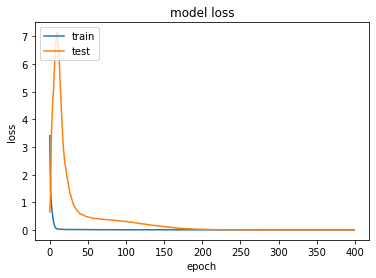

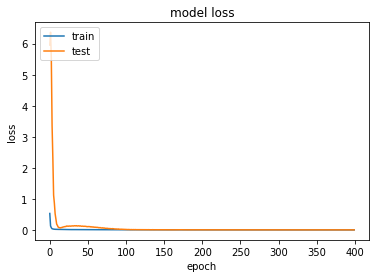

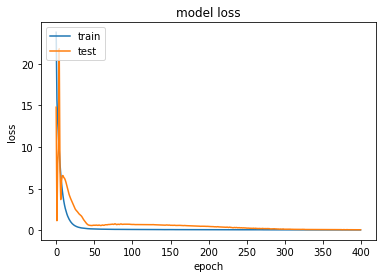

In [122]:

plot_loss(history_benzene)
plot_loss(history_carbon)
plot_loss(history_nitrogen)

In [123]:
ypred_benzene = model_benzene.predict(X_test)
ypred_carbon = model_carbon.predict(X_test)
ypred_nitrogen = model_nitrogen.predict(X_test)

In [124]:
pred_benzene = list(np.concatenate(ypred_benzene.tolist()).flat)
y_test_benzene = list(ytst_benzene)

pred_carbon = list(np.concatenate(ypred_carbon.tolist()).flat)
y_test_carbon = list(ytst_carbon)

pred_nitrogen = list(np.concatenate(ypred_nitrogen.tolist()).flat)
y_test_nitrogen = list(ytst_nitrogen)


Testing MAPE


In [125]:
mape_b = mape(y_test_benzene, pred_benzene).numpy()
mape_c = mape(y_test_carbon, pred_carbon).numpy()
mape_n = mape(y_test_nitrogen, pred_nitrogen).numpy()
(mape_b+mape_c+mape_n)/3

27.979142506917317

Testing MAE

In [126]:
mae_b = mae(y_test_benzene, pred_benzene).numpy()
mae_c = mae(y_test_carbon, pred_carbon).numpy()
mae_n = mae(y_test_nitrogen, pred_nitrogen).numpy()
(mae_b+mae_c+mae_n)/3

12.861121609807014

Testing RMSLE

In [127]:
rmsleb = np.sqrt(msle(y_test_benzene,pred_benzene))
rmslec = np.sqrt(msle(y_test_carbon, pred_carbon))
rmslen = np.sqrt(msle(y_test_nitrogen, pred_nitrogen)) 
(rmsleb + rmslec + rmslen)/3

0.1544513099116237

Testing RMSE

In [128]:
mse_b = np.sqrt(mse(y_test_benzene, pred_benzene).numpy())
mse_c = np.sqrt(mse(y_test_carbon, pred_carbon).numpy())
mse_n = np.sqrt(mse(y_test_nitrogen, pred_nitrogen).numpy())
(mse_b+mse_c+mse_n)/3

22.73903913466287

Testing $R^2$

In [129]:
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_test_nitrogen, pred_nitrogen)
r2_b = metric.result()
metric.update_state(y_test_nitrogen, pred_nitrogen)
r2_c = metric.result()
metric.update_state(y_test_nitrogen, pred_nitrogen)
r2_n = metric.result()
((r2_b + r2_c + r2_n)/3).numpy()

0.88648134